# Models for Multi-Reviewer Labels

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
from keras.applications.inception_v3 import InceptionV3

In [3]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from keras_addon import ImageFrameGenerator, AUCCheckPoint

from DL_utils import plot_roc

In [40]:
path  =  "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/colonoscopy2/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)
data_path = path+'subset_adjudication/'

In [6]:
batch_size = 32

## Preparation
Check up the labels and image files. Split into training and validation sets. 

In [18]:
filenames = os.listdir(path+'all_images/')

In [7]:
labels = pd.read_csv(path+'UC_FINAL_Adjudication.csv')

In [11]:
pd.crosstab(labels.Mayo_Rev1_Corrected, labels.Mayo_Rev2_Corrected, margins=True)

Mayo_Rev2_Corrected,0,1,2,3,All
Mayo_Rev1_Corrected,,,,,
0,7058,2049,52,1,9160
1,500,1875,1040,15,3430
2,5,144,1667,589,2405
3,0,1,217,1301,1519
All,7563,4069,2976,1906,16514


In [13]:
pd.crosstab(labels.Mayo_Rev1_Corrected, labels.Mayo_Rev2_Corrected, normalize='index')

Mayo_Rev2_Corrected,0,1,2,3
Mayo_Rev1_Corrected,,,,
0,0.770524,0.223690,0.005677,0.000109
1,0.145773,0.546647,0.303207,0.004373
2,0.002079,0.059875,0.693139,0.244906
3,0.000000,0.000658,0.142857,0.856485


In [14]:
pd.crosstab(labels.adj_score, labels.Mayo_Rev2_Corrected, normalize='index')

Mayo_Rev2_Corrected,0,1,2,3
adj_score,,,,
0,0.819826,0.159745,0.019647,0.000781
1,0.061999,0.755859,0.172056,0.010086
2,0.003228,0.035109,0.843826,0.117837
3,0.001172,0.001757,0.075571,0.921500


Make a subset copy of the images, so the generator can run faster. 

In [15]:
labels.shape

(16514, 7)

In [19]:
labeled = set(labels.basefile)

from shutil import copyfile

for f in filenames:
    if f in labeled:
        copyfile(path+'all_images/'+f, path+'subset_adjudication/'+f)

Create labels for multi-binary classification:

In [22]:
labels['split0_123'] = (labels.adj_score>0).astype(int)
labels['split01_23'] = (labels.adj_score>1).astype(int)
labels['split012_3'] = (labels.adj_score>2).astype(int)

In [23]:
labels.head()

,basefile,pathname,SourceReportName,Mayo_Rev1_Corrected,Mayo_Rev2_Corrected,Corrected_ScoreDiff,adj_score,split0_123,split01_23,split012_3
0,BM_col_1000-2.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,2,3,1,2,1,1,0
1,BM_col_1000-3.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,2,3,1,2,1,1,0
2,BM_col_1000-5.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,0,0,0,0,0,0
3,BM_col_1000-6.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,1,1,0,0,0,0
4,BM_col_1000-7.jpg,E:\TEMP\AS\UPDATED FILES\Colon_Images_Original...,BM_col_1000,0,0,0,0,0,0,0


In [25]:
labels.split0_123.value_counts(), labels.split01_23.value_counts(), labels.split012_3.value_counts()

(0    8958
 1    7556
 Name: split0_123, dtype: int64, 0    12329
 1     4185
 Name: split01_23, dtype: int64, 0    14807
 1     1707
 Name: split012_3, dtype: int64)

In [26]:
labels.adj_score.value_counts()

0    8958
1    3371
2    2478
3    1707
Name: adj_score, dtype: int64

In [27]:
len(labels), len(labels.SourceReportName.value_counts())

(16514, 3082)

Splitting of training/validation and testing (I use "train" to denote training and validation data, and "tst" to denote testing data; use "trn" and "val" for the training/validation splitting):

In [28]:
labels = labels.reset_index(drop=True)
split = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
train_ind, tst_ind = next(ind)
train_patients = set(labels.loc[train_ind, 'SourceReportName'])
tst_patients = set(labels.loc[tst_ind, 'SourceReportName'])
train_df = labels.loc[train_ind]
tst_df = labels.loc[tst_ind]

In [29]:
train_ind.shape, tst_ind.shape, len(train_patients), len(tst_patients)

((14847,), (1667,), 2773, 309)

In [30]:
train_df.to_csv(path+'train_labels.csv', index=False)
tst_df.to_csv(path+'tst_labels.csv', index=False)

Splitting of training and validation sets:

In [31]:
labels = pd.read_csv(path+'train_labels.csv')

In [32]:
labels = labels.reset_index(drop=True)
split = GroupShuffleSplit(n_splits=1, test_size=0.11, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
trn_ind, val_ind = next(ind)

trn_patients = set(labels.loc[trn_ind, 'SourceReportName'])
val_patients = set(labels.loc[val_ind, 'SourceReportName'])

trn_df = labels.loc[trn_ind]
val_df = labels.loc[val_ind]

In [33]:
trn_ind.shape, val_ind.shape, len(trn_patients), len(val_patients)

((13165,), (1682,), 2467, 306)

In [34]:
val_df.split012_3.value_counts()

0    1493
1     189
Name: split012_3, dtype: int64

In [35]:
val_df.adj_score.value_counts()

0    863
1    330
2    300
3    189
Name: adj_score, dtype: int64

## Data Generator

In [37]:
from keras_addon import ImageFrameGenerator

In [56]:
import keras_addon
from importlib import reload
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [38]:
train_gen = ImageFrameGenerator( 
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [39]:
validation_gen = ImageFrameGenerator()

In [41]:
trn_itr = train_gen.flow_from_frame(data_path, trn_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 13165 images to generate mini-batches.


In [42]:
val_itr = validation_gen.flow_from_frame(data_path, val_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1682 images to generate mini-batches.


## Model with 3 binary output

In [43]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [45]:
checkpointer = ModelCheckpoint(filepath=model_path+'binary3_valloss_1111.h5', verbose=0, save_best_only=True, 
                               save_weights_only=True)
auccheckpt = AUCCheckPoint(filepath=model_path+'binary3_auc_1111.h5', 
                           validation_y=val_df[['split0_123', 'split01_23', 'split012_3']].values, validation_itr=val_itr)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=40)

In [46]:
class_weight = {'split0_123':{0:len(trn_df)/sum(trn_df.split0_123==0), 1:len(trn_df)/sum(trn_df.split0_123==1)}, 
               'split01_23':{0:len(trn_df)/sum(trn_df.split01_23==0), 1:len(trn_df)/sum(trn_df.split01_23==1)}, 
               'split012_3':{0:len(trn_df)/sum(trn_df.split012_3==0), 1:len(trn_df)/sum(trn_df.split012_3==1)}}

In [47]:
class_weight

{'split012_3': {0: 1.1147332768839966, 1: 9.715867158671587},
 'split01_23': {0: 1.3355990666531399, 1: 3.979746070133011},
 'split0_123': {0: 1.8350989684973515, 1: 2.1974628609581037}}

In [48]:
history = model.fit_generator(trn_itr, steps_per_epoch=trn_itr.n // batch_size, epochs=3, 
                              validation_data=val_itr, validation_steps=val_itr.n // batch_size, 
                              callbacks=[checkpointer, auccheckpt, reduce_lr, earlystop], class_weight = class_weight, 
                                verbose=1)

Epoch 1/3
411/411 [==============================] - 618s 2s/step - loss: 2.8028 - split0_123_loss: 1.0714 - split01_23_loss: 0.9354 - split012_3_loss: 0.7960 - val_loss: 1.7487 - val_split0_123_loss: 0.8290 - val_split01_23_loss: 0.5707 - val_split012_3_loss: 0.3490
AUC_split0_123: 0.8075
AUC_split01_23: 0.8524
AUC_split012_3: 0.8262
Mean AUC: 0.8287

Epoch 2/3
411/411 [==============================] - 590s 1s/step - loss: 2.3956 - split0_123_loss: 0.9487 - split01_23_loss: 0.7934 - split012_3_loss: 0.6536 - val_loss: 1.5054 - val_split0_123_loss: 0.5926 - val_split01_23_loss: 0.4584 - val_split012_3_loss: 0.4545
AUC_split0_123: 0.8455
AUC_split01_23: 0.8751
AUC_split012_3: 0.8107
Mean AUC: 0.8437

Epoch 3/3
411/411 [==============================] - 589s 1s/step - loss: 2.2939 - split0_123_loss: 0.9185 - split01_23_loss: 0.7585 - split012_3_loss: 0.6169 - val_loss: 0.9783 - val_split0_123_loss: 0.4411 - val_split01_23_loss: 0.3127 - val_split012_3_loss: 0.2245
AUC_split0_123: 0.8839

In [19]:
auccheckpt.auc_history

{'split012_3': [0.5990349264705882,
  0.9641653536414567,
  0.804107580532213,
  0.949076505602241,
  0.9738817401960784],
 'split01_23': [0.5405084873632591,
  0.9512214258770275,
  0.7472802715956244,
  0.9368359109769899,
  0.9659298377970578],
 'split0_123': [0.46521171107664827,
  0.909426194839983,
  0.7528568071807886,
  0.9019314817425632,
  0.6948230649936558]}

### Result Evaluation

In [65]:
with open('output/binary3_auc_0528.pkl', 'rb') as f:
    auc_history = pickle.load(f)

Text(0,0.5,'AUCs')

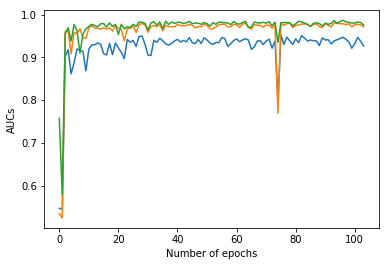

In [66]:
plt.plot(auc_history['split0_123'])
plt.plot(auc_history['split01_23'])
plt.plot(auc_history['split012_3'])
plt.xlabel('Number of epochs')
plt.ylabel('AUCs')

In [49]:
tst_df = pd.read_csv(path+'tst_labels.csv')
tst_df = tst_df.reset_index(drop=True)

In [50]:
validation_gen = ImageFrameGenerator()

In [51]:
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 16514 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1667 images to generate mini-batches.


In [52]:
model.load_weights(model_path+'binary3_auc_1111.h5')

In [53]:
y = model.predict_generator(tst_itr, verbose=1)

53/53 [==============================] - 24s 458ms/step


In [54]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [55]:
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

In [56]:
y_pred.shape, y_true.shape

((1667, 3), (1667, 3))

{0: 0.8703516110533775, 1: 0.9198552348403632, 2: 0.9231211656441717}

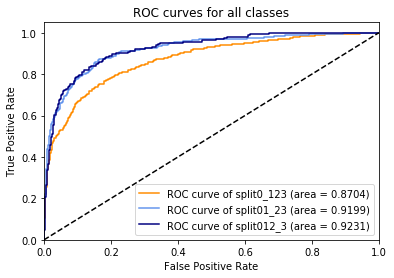

In [57]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

In [46]:
y_pred

array([[5.99314153e-01, 2.28909478e-02, 1.07496395e-03],
       [8.61447155e-01, 1.06399626e-01, 3.75232834e-04],
       [9.84677792e-01, 5.70016980e-01, 1.62384529e-02],
       ...,
       [5.58475222e-05, 1.10411385e-07, 1.36902200e-11],
       [1.45818262e-06, 2.15458140e-09, 2.50117960e-13],
       [1.26331742e-03, 9.31455659e-08, 8.23103807e-11]], dtype=float32)

In [103]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

In [48]:
score4[:, 0] = 1 - y_pred[:, 0]
for j in range(1, score4.shape[1]-1):
    score4[:, j] = y_pred[:, j-1] - y_pred[:, j]
score4[:, -1] = y_pred[:, -1]

In [104]:
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

In [90]:
sum(score4<0)

array([0, 0, 0, 0])

In [105]:
mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [106]:
mayo_true = tst_df.Mayo_score
mayo_true.name = 'Mayo_true'

In [107]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,771,73,2,0,846
1,139,216,26,5,386
2,7,36,61,34,138
3,1,7,28,112,148
All,918,332,117,151,1518


In [53]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.911348,0.085106,0.003546,0.000000
1,0.362694,0.551813,0.067358,0.018135
2,0.043478,0.260870,0.442029,0.253623
3,0.006757,0.047297,0.175676,0.770270


In [58]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.911348,0.086288,0.002364,0.000000
1,0.360104,0.559585,0.067358,0.012953
2,0.050725,0.260870,0.442029,0.246377
3,0.006757,0.047297,0.189189,0.756757


In [108]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear')

0.7396376450801716

In [109]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic')

0.8542864776064767

## Test on Video data

In [8]:
vfilenames = os.listdir(path+'all_video_images/')

In [9]:
vfilenames = set(vfilenames)

In [10]:
video_labels = pd.read_excel(path+'VideoTestSet_labels_27MAY2018.xlsx')

In [119]:
video_labels.columns

Index(['ID', 'basefile', 'pathname', 'file_seq', 'SubjectID', 'Mayo_0',
       'Mayo_1', 'Mayo_2', 'Mayo_3'],
      dtype='object')

In [11]:
video_labels['filename'] = [s+b for s, b in zip(video_labels.SubjectID, video_labels.basefile)]

In [12]:
video_labels = video_labels.loc[video_labels.filename.isin(vfilenames)]

In [13]:
subjects = '001 007 008 010 037 045 046 052 057 060 061 Lycera_001 Lycera_002 Lycera_003 Lycera_005 Lycera_006 079 088 089 091 093 096'.split()

In [14]:
video_labels = video_labels.loc[video_labels.SubjectID.isin(subjects)]

In [15]:
len(video_labels.SubjectID.value_counts())

22

In [16]:
video_labels = video_labels.loc[video_labels[['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3']].apply(sum, axis=1)==1]

In [17]:
video_labels = video_labels.dropna(subset=['filename', 'Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'])

In [18]:
video_labels['split0_123'] = (~video_labels.Mayo_0).astype(int)
video_labels['split01_23'] = (video_labels.Mayo_2 | video_labels.Mayo_3).astype(int)
video_labels['split012_3'] = video_labels.Mayo_3.astype(int)

In [19]:
video_labels['Mayo_score'] = 0
video_labels.loc[video_labels.Mayo_1, 'Mayo_score'] = 1
video_labels.loc[video_labels.Mayo_2, 'Mayo_score'] = 2
video_labels.loc[video_labels.Mayo_3, 'Mayo_score'] = 3

In [20]:
video_labels.Mayo_score.value_counts()

0    5605
1     977
2     659
3     256
Name: Mayo_score, dtype: int64

In [21]:
video_labels.shape

(7497, 14)

In [22]:
video_labels.to_csv(path+'video_labels.csv', index=False)

### Prediction by 3 binary model

In [47]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(path+'all_video_images/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 15072 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 7497 images to generate mini-batches.


In [48]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [73]:
model.load_weights(model_path+'binary3_valloss_0528.h5')

In [74]:
y = model.predict_generator(tst_itr, verbose=1)

235/235 [==============================] - 208s 884ms/step


In [75]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)

In [76]:
y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values

In [53]:
y_pred.shape, y_true.shape

((7497, 3), (7497, 3))

{0: 0.9630059803897532, 1: 0.9805663068511073, 2: 0.9941527629125811}

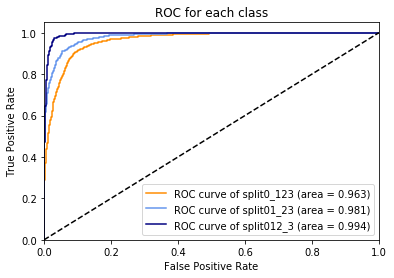

In [77]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

In [68]:
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)

In [69]:
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

In [70]:
mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')

In [58]:
mayo_true = video_labels.Mayo_score.reset_index(drop=True)
mayo_true.name = 'Mayo_true'

In [66]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,5038,490,48,29,5605
1,140,711,115,11,977
2,20,123,434,82,659
3,0,1,19,236,256
All,5198,1325,616,358,7497


In [67]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.898840,0.087422,0.008564,0.005174
1,0.143296,0.727738,0.117707,0.011259
2,0.030349,0.186646,0.658574,0.124431
3,0.000000,0.003906,0.074219,0.921875


In [71]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear')

0.7274866302283287

In [72]:
cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic')

0.8118400398385246

## Cross Validation

### Splitting for 10-fold cross validation

In [64]:
from sklearn.model_selection import GroupKFold

In [58]:
train_df = pd.read_csv(path+'train_labels.csv')
tst_df = pd.read_csv(path+'tst_labels.csv')

In [59]:
all_df = pd.concat([train_df, tst_df])

In [60]:
all_df = all_df.reset_index(drop=True)

In [63]:
all_df.shape, len(all_df.SourceReportName.value_counts())

((16514, 10), 3082)

In [67]:
split = GroupKFold(n_splits=10)

In [68]:
fold = 0
for train_ind, tst_ind in split.split(all_df, groups=all_df.SourceReportName):
    train_df = all_df.loc[train_ind]
    tst_df = all_df.loc[tst_ind]
    train_df.to_csv(path+'CV_adjudication/train_labels'+str(fold)+'.csv', index=False)
    tst_df.to_csv(path+'CV_adjudication/tst_labels'+str(fold)+'.csv', index=False)
    fold += 1

In [69]:
patient_sets = []
for j in range(10):
    df = pd.read_csv(path+'CV_adjudication/tst_labels'+str(j)+'.csv')
    patient_sets.append(set(df.SourceReportName))

In [70]:
[len(s) for s in patient_sets]

[308, 308, 309, 309, 308, 308, 308, 308, 308, 308]

In [75]:
for ps in patient_sets:
    print(len(patient_sets[7].intersection(ps)))

0
0
0
0
0
0
0
308
0
0


### Summary of Results

In [28]:
from sklearn.metrics import roc_curve, auc

In [29]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(2, activation='softmax', name='split0_123')(x)
output2 = Dense(2, activation='softmax', name='split01_23')(x)
output3 = Dense(2, activation='softmax', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [30]:
validation_gen = ImageFrameGenerator()

In [36]:
auc01_23 = []
acc01 = []
acc23 = []
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []

In [37]:
for cv in range(1, 11):
    tst_df = pd.read_csv(path+'cross_validation/tst_labels'+str(cv)+'.csv')
    tst_df = tst_df.reset_index(drop=True)
    tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)
    model.load_weights(model_path+'cross_validation/binary3_auc'+str(cv)+'.h5')
    y = model.predict_generator(tst_itr, verbose=1)

    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
    y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    auc01_23.append(auc(fpr, tpr))
    
    acc01.append(sum((y_pred[:, 1]<0.5) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
    acc23.append(sum((y_pred[:, 1]>0.5) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
    
    score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
    score4[:, 0] = 1 - y_pred[:, 0]
    score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
    score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
    score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

    mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
    mayo_true = tst_df.Mayo_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic'))

Found 14830 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1518 images to generate mini-batches.
48/48 [==============================] - 26s 550ms/step
Found 14830 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1496 images to generate mini-batches.
47/47 [==============================] - 22s 478ms/step
Found 14830 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1572 images to generate mini-batches.
50/50 [==============================] - 23s 463ms/step
Foun

In [11]:
import statsmodels.stats.api as sms

In [38]:
np.savez('output/cv_auc.npz', auc01_23=auc01_23, acc01=acc01, acc23=acc23, acc0=acc0, acc1=acc1, acc2=acc2, acc3=acc3, 
         kappa_l=kappa_linear, kappa_q=kappa_quad)

In [38]:
load = np.load('output/cv.npz')

In [49]:
print('{0:.4f}'.format(np.mean(load['auc01_23'])))

print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load['auc01_23']).tconfint_mean()))

0.9779
(0.9755, 0.9802)


In [40]:
load['kappa_q']

array([0.86261234, 0.85801092, 0.84547595, 0.84217488, 0.85860648,
       0.84099532, 0.87636452, 0.86569853, 0.8550634 , 0.84805459])

In [47]:
tst_df = pd.read_csv(path+'cross_validation/tst_labels9.csv')
tst_df = tst_df.reset_index(drop=True)
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), label_types = ['categorical']*3, batch_size=batch_size, 
                                         shuffle=False)

Found 14830 images in the directory.
Using split0_123 as categorical label, with levels: {0: 0, 1: 1}
Using split01_23 as categorical label, with levels: {0: 0, 1: 1}
Using split012_3 as categorical label, with levels: {0: 0, 1: 1}
Using 1480 images to generate mini-batches.


In [48]:
model.load_weights(model_path+'cross_validation/binary3_valloss9.h5')
y = model.predict_generator(tst_itr, verbose=1)

47/47 [==============================] - 28s 594ms/step


In [49]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values
    
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
mayo_true = tst_df.Mayo_score
mayo_true.name = 'Mayo_true'

{0: 0.984615437565178}

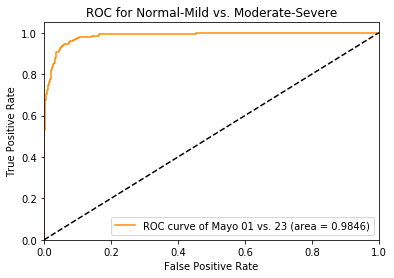

In [50]:
plot_roc(y_pred[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', 
         savefile = 'output/roc01_23.tiff')

In [51]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,863,58,4,0,925
1,135,167,19,1,322
2,2,40,61,10,113
3,0,10,27,83,120
All,1000,275,111,94,1480


In [52]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.932973,0.062703,0.004324,0.000000
1,0.419255,0.518634,0.059006,0.003106
2,0.017699,0.353982,0.539823,0.088496
3,0.000000,0.083333,0.225000,0.691667


### Cross Validation on Video Data

In [7]:
video_labels = pd.read_csv(path+'video_labels.csv')

In [8]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(path+'all_video_images/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 15072 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 7497 images to generate mini-batches.


In [38]:
auc01_23 = []
acc01 = []
acc23 = []
acc0 = []
acc1 = []
acc2 = []
acc3 = []
kappa_linear = []
kappa_quad = []

In [ ]:
for cv in range(1, 11):
    model.load_weights(model_path+'cross_validation/binary3_valloss'+str(cv)+'.h5')
    y = model.predict_generator(tst_itr, verbose=1)

    y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
    y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values

    fpr, tpr, _ = roc_curve(y_true[:, 1], y_pred[:, 1])
    auc01_23.append(auc(fpr, tpr))
    
    acc01.append(sum((y_pred[:, 1]<0.5) & (y_true[:, 1]==0))/sum(y_true[:, 1]==0))
    acc23.append(sum((y_pred[:, 1]>0.5) & (y_true[:, 1]==1))/sum(y_true[:, 1]==1))
    
    score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
    score4[:, 0] = 1 - y_pred[:, 0]
    score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
    score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
    score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

    mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
    mayo_true = video_df.Mayo_score
    mayo_true.name = 'Mayo_true'
    
    acc0.append(sum((mayo_pred==0) & (mayo_true==0))/sum(mayo_true==0))
    acc1.append(sum((mayo_pred==1) & (mayo_true==1))/sum(mayo_true==1))
    acc2.append(sum((mayo_pred==2) & (mayo_true==2))/sum(mayo_true==2))
    acc3.append(sum((mayo_pred==3) & (mayo_true==3))/sum(mayo_true==3))

    kappa_linear.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='linear'))
    kappa_quad.append(cohen_kappa_score(mayo_pred.values, mayo_true.values, weights='quadratic'))

221/235 [===========================>..] - ETA: 28s

In [9]:
import statsmodels.stats.api as sms

In [38]:
np.savez('output/cv_video.npz', auc01_23=auc01_23, acc01=acc01, acc23=acc23, acc0=acc0, acc1=acc1, acc2=acc2, acc3=acc3, 
         kappa_l=kappa_linear, kappa_q=kappa_quad)

In [11]:
load = np.load('output/cv_video.csv.npz')

In [26]:
quant = 'kappa_q'
print('{0:.4f}'.format(np.mean(load[quant])))
print('({0:.4f}, {1:.4f})'.format(*sms.DescrStatsW(load[quant]).tconfint_mean()))

0.8208
(0.8030, 0.8386)


In [27]:
load['kappa_q']

array([0.84936455, 0.78959016, 0.82597789, 0.80483156, 0.81998876,
       0.80572939, 0.82666238, 0.85805186, 0.78418327, 0.84335693])

In [31]:
model.load_weights(model_path+'cross_validation/binary3_valloss8.h5')
y = model.predict_generator(tst_itr, verbose=1)

235/235 [==============================] - 257s 1s/step


In [34]:
y_pred = np.concatenate([l[:, 1].reshape((l.shape[0], 1)) for l in y], axis=1)
y_true = video_labels[['split0_123', 'split01_23', 'split012_3']].values
    
score4 = np.zeros((y_pred.shape[0], y_pred.shape[1]+1), dtype=float)
score4[:, 0] = 1 - y_pred[:, 0]
score4[:, 1] = y_pred[:, 0]*(1-y_pred[:,1])
score4[:, 2] = y_pred[:, 0]*y_pred[:,1]*(1-y_pred[:,2])
score4[:, 3] = y_pred[:, 0]*y_pred[:,1]*y_pred[:,2]

mayo_pred = pd.Series(score4.argmax(axis=1), name='Mayo_pred')
mayo_true = video_labels.Mayo_score
mayo_true.name = 'Mayo_true'

{0: 0.9789437329494416}

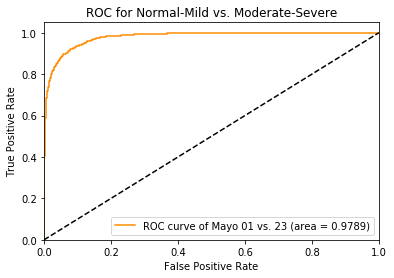

In [35]:
plot_roc(y_pred[:, 1], y_true[:, 1], classes=['Mayo 01 vs. 23'], title='ROC for Normal-Mild vs. Moderate-Severe', 
         savefile = 'output/roc01_23_video.tiff')

In [36]:
pd.crosstab(index=mayo_true, columns=mayo_pred, margins=True)

Mayo_pred,0,1,2,3,All
Mayo_true,,,,,
0,5197,380,24,4,5605
1,252,683,39,3,977
2,16,226,396,21,659
3,0,11,70,175,256
All,5465,1300,529,203,7497


In [37]:
pd.crosstab(index=mayo_true, columns=mayo_pred, normalize='index')

Mayo_pred,0,1,2,3
Mayo_true,,,,
0,0.927208,0.067797,0.004282,0.000714
1,0.257932,0.699079,0.039918,0.003071
2,0.024279,0.342944,0.600910,0.031866
3,0.000000,0.042969,0.273438,0.683594
